<a href="https://colab.research.google.com/github/IvanKatorgin/Time-series/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Временные ряды". Домашнее задание 5. Сингулярный спектральный анализ. Каторгин И.П.

Описание задания:
1. Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
2. При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
3. Посмотрите на результаты с разными длинами окон.
4. Обязательно визуализируйте результаты аналогично материалу с занятия.

In [74]:
# загрузим библиотеки
import numpy as np, pandas as pd, seaborn as sns, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from scipy.stats import boxcox
from scipy.optimize import minimize
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa import ar_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from cycler import cycler

In [75]:
# загрузим данные
female_births = pd.read_csv('daily-total-female-births-in-cal.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
airlines_passengers = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', sep = ',', header = 0, encoding = 'utf-8')['Deg']
robberies_in_boston = pd.read_csv('monthly-boston-armed-robberies-j.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
dowjones_closing = pd.read_csv('weekly-closings-of-the-dowjones-.csv', sep = ',', header = 0, encoding = 'utf-8')['Close']

In [76]:
all_series = {
    "Monthly sales of company X": sales_of_company_x,
    "Monthly Boston armed robberies": robberies_in_boston,
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp,
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing,
    "Daily total female births in California": female_births
}

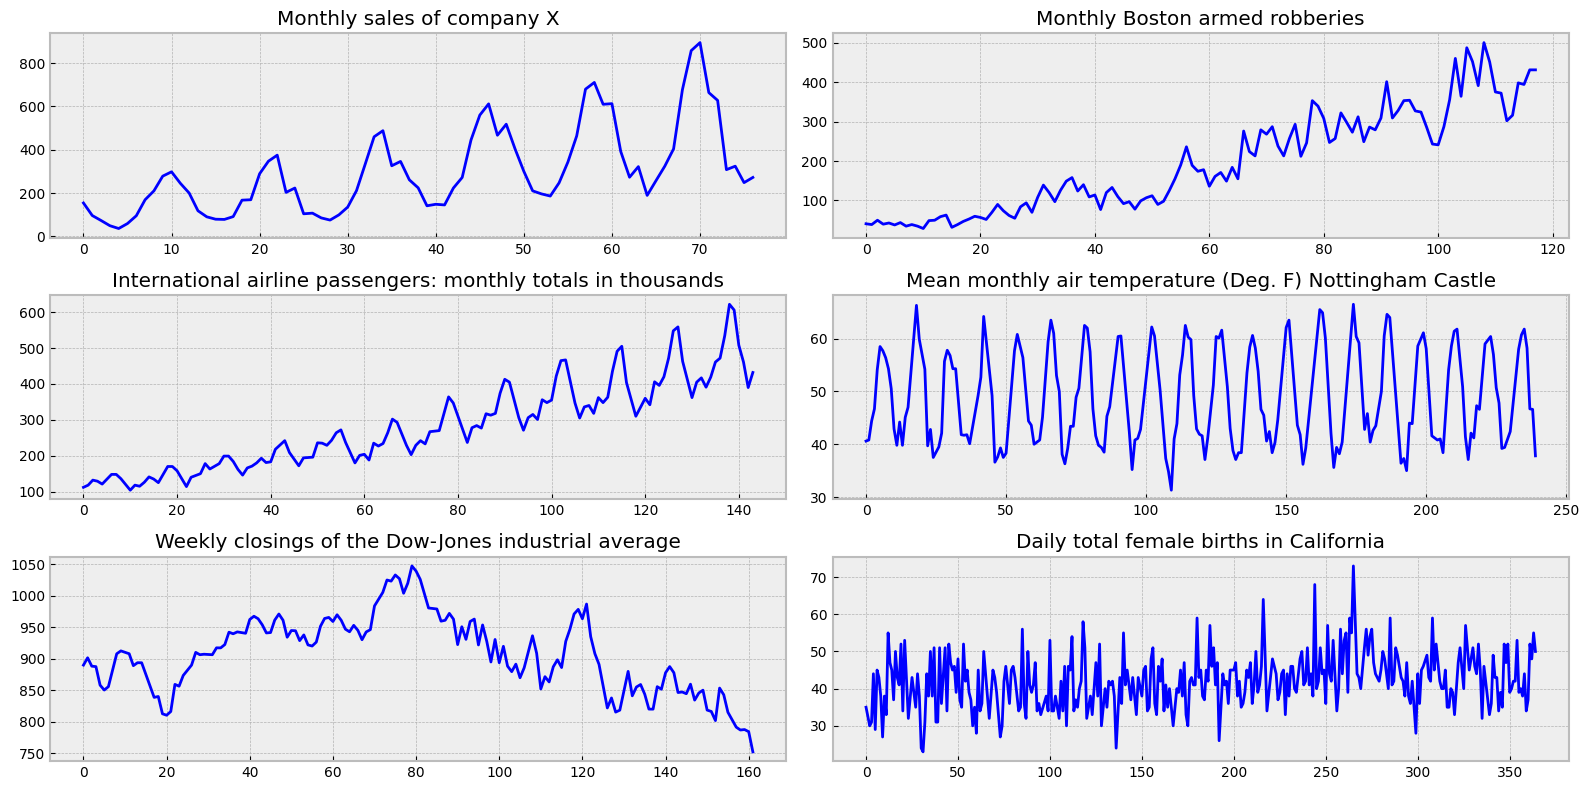

In [77]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Возьмем временной ряд airlines_passengers, т.к. там есть и сезонность и тренд

In [78]:
# длину окна возьмем равной 50
N = len(airlines_passengers)
L = 50 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([airlines_passengers[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive.

Text(0.5, 1.0, 'The Trajectory Matrix for the airlines_passengers')

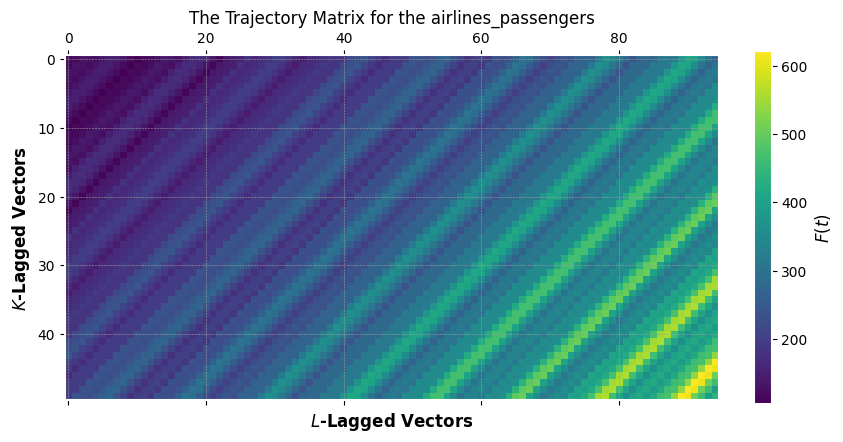

In [143]:
# возьмем момент, чтобы оценить матрицу траекторий во всей ее антидиагональной красоте:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the airlines_passengers")

In [80]:
# разложим матрицу траекторий и сформируем ее элементарные матрицы:
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

In [81]:
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

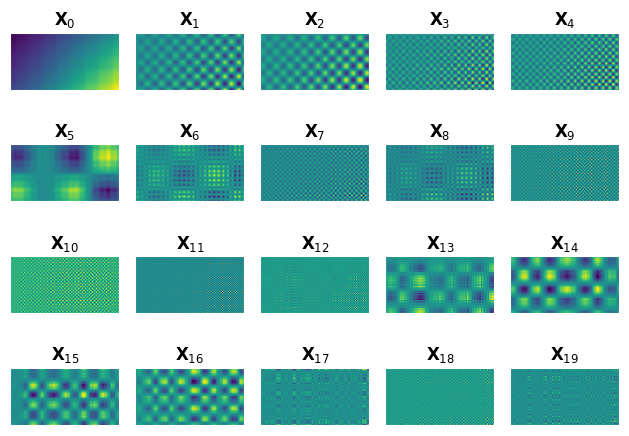

In [82]:
# рисуем элементарные матрицы
n = min(20, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,5,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

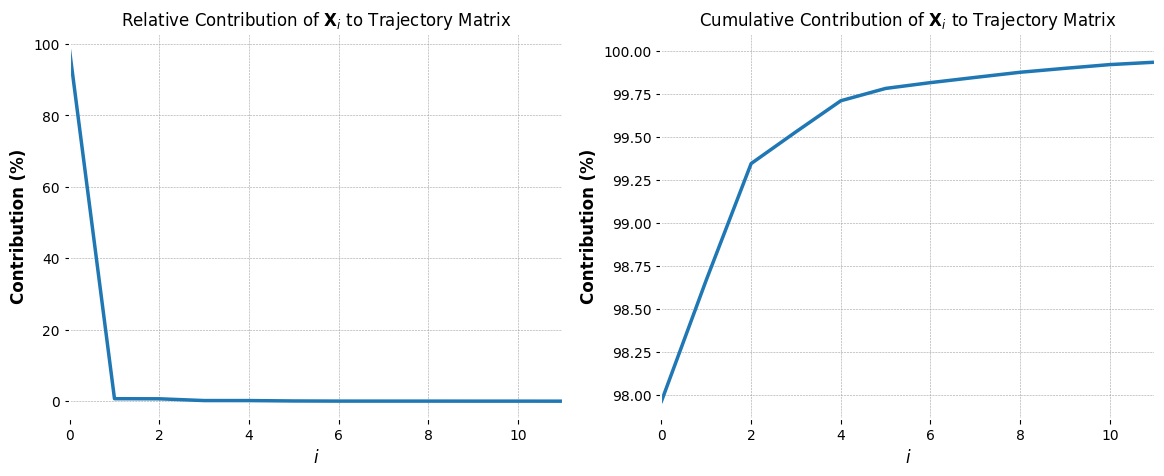

In [83]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Наибольший вклад вносят первые 5 элементов

In [84]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

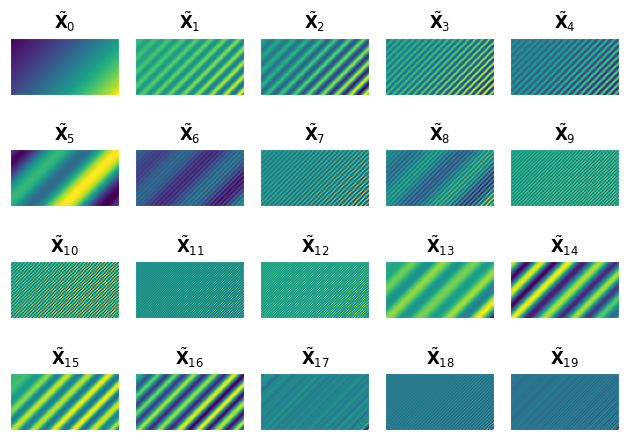

In [85]:
n = min(d, 20)
for j in range(0,n):
    plt.subplot(4,5,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

X0 - главнй тренд. Следующие пары можно просуммировать друг с другом:
- Х1 и Х2
- Х3 и Х4
- Х5, Х6, Х8
- Х13 и Х14
- Х15 и Х16
- Остальное - шум

In [86]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

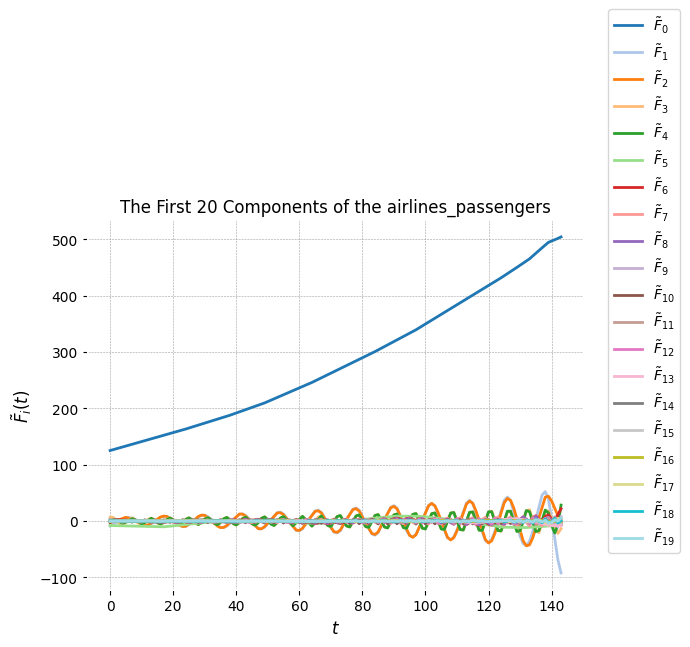

In [145]:
n = min(20,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F=airlines_passengers, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 20 Components of the airlines_passengers")
fig.legend(legend, loc=(1.05,0.1));

На графике четко виден тренд (F0), сезонность 1 (F1), сезонность 2 (F2) и сезонность 3 (F4)

In [88]:
F=airlines_passengers

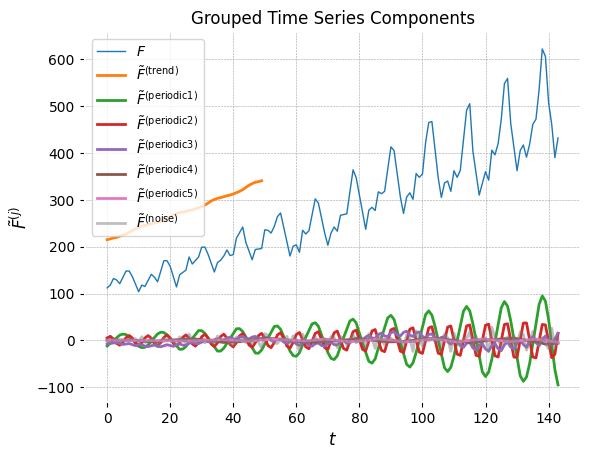

In [158]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]])
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F_periodic3 = X_to_TS(X_elem[[5,6,8]].sum(axis=0))
F_periodic4 = X_to_TS(X_elem[[13,14]].sum(axis=0))
F_periodic5 = X_to_TS(X_elem[[15,16]].sum(axis=0))
F_noise_1 = X_to_TS(X_elem[[7,9,10,11,12]].sum(axis=0))
F_noise_2 = X_to_TS(X_elem[17:].sum(axis=0))
F_noise = F_noise_1 + F_noise_2

# Plot the toy time series and its separated components on a single plot.
plt.plot(F, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)
plt.plot(F_periodic2)
plt.plot(F_periodic3)
plt.plot(F_periodic4)
plt.plot(F_periodic5)
plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "periodic 3", "periodic 4", "periodic 5", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [98]:
# построим w-корреляционную матрицу для нашего временного ряда:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

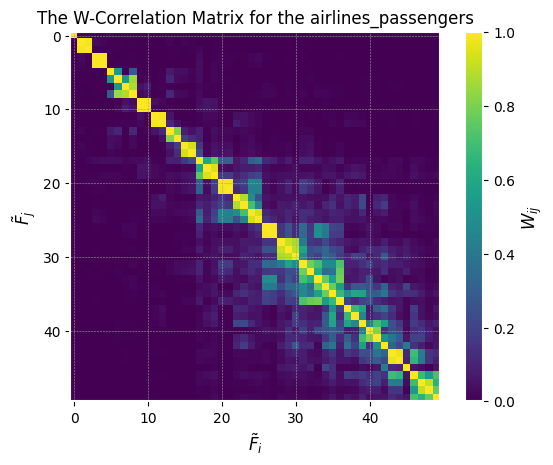

In [146]:
# График w-корреляционной матрицы
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the airlines_passengers");

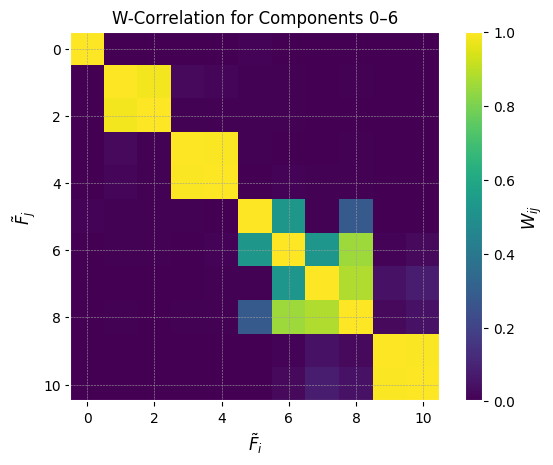

In [101]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,10.5)
plt.ylim(10.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

In [102]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)


Посмотрим на разные длины окна

L=2

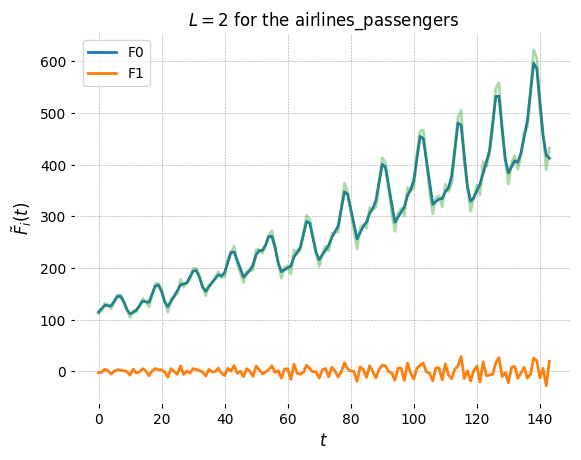

In [147]:
F_ssa_L2 = SSA(F, L=2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the airlines_passengers");

L=5

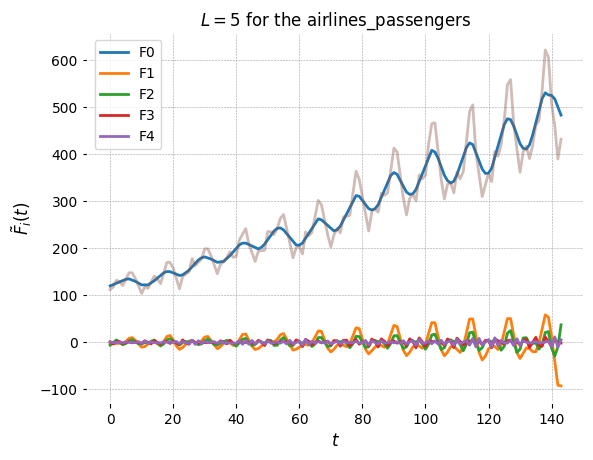

In [148]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the airlines_passengers");
plt.show()

L=20

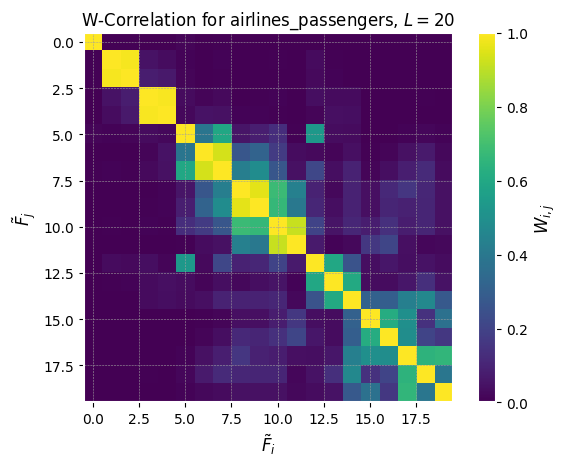

In [149]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for airlines_passengers, $L=20$");

w-корреляционная матрица для  L=20  разбита (грубо) на шесть блоков:
- F0
- F1
- F2
- F3 to F4
- F5 to F12
- F13 to F19.

Построим выбранные нами группировки компонентов и посмотрим, оправдан ли наш выбор группировки:

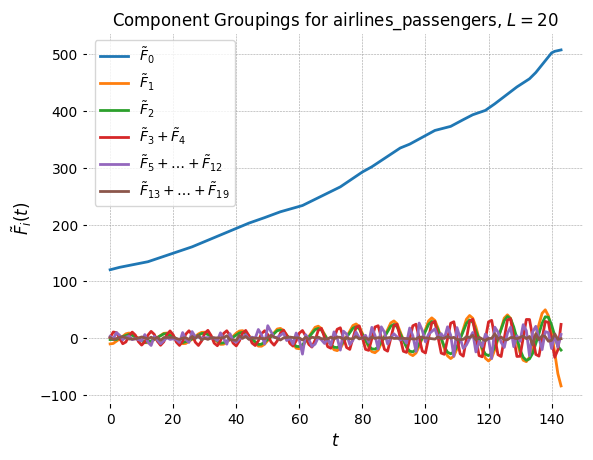

In [150]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1]).plot()
F_ssa_L20.reconstruct([2]).plot()
F_ssa_L20.reconstruct([3,4]).plot()
F_ssa_L20.reconstruct([5,6,7,8,9,10,11,12]).plot()
F_ssa_L20.reconstruct(slice(13,19)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for airlines_passengers, $L=20$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1$",
            r"$\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_5+ \ldots +\tilde{F}_{12}$",
            r"$\tilde{F}_{13}+ \ldots + \tilde{F}_{19}$"]);

Четко виден главный тренд, сезонности и шум

L=40

удвоим длину окна, приблизившись тем самым к начальному размеру окна и сначала проверим w-корреляционную матрицу

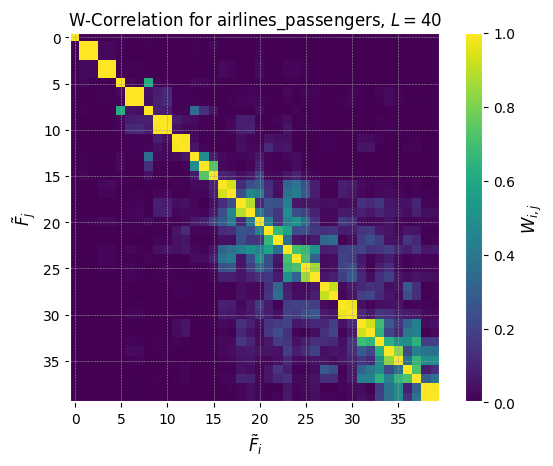

In [151]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for airlines_passengers, $L=40$");

Структура в целом повторяется, видно, что начиная с F15, все признаки можно объединить

Просмотр w-корреляционной матрицы для компонентов 0-6:

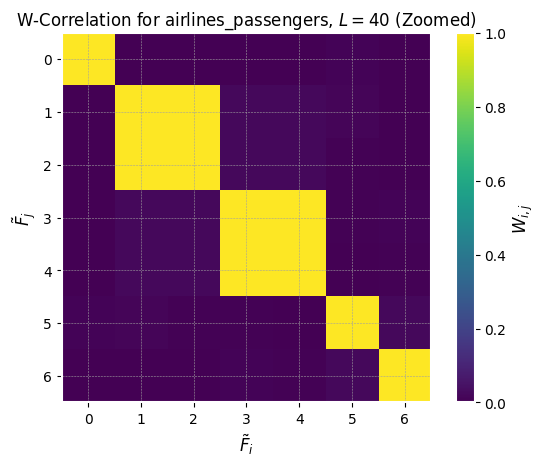

In [152]:
F_ssa_L40.plot_wcorr(max=6)
plt.title("W-Correlation for airlines_passengers, $L=40$ (Zoomed)");

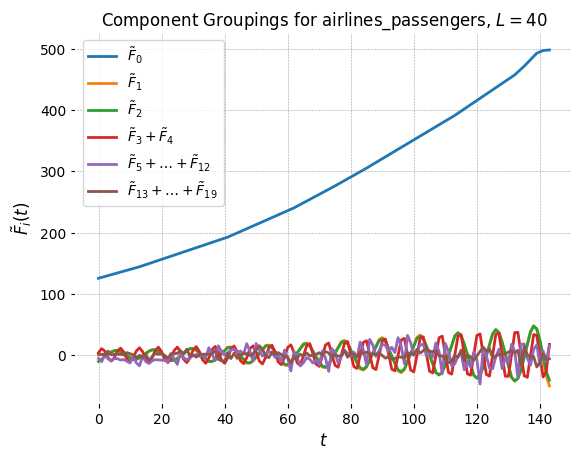

In [153]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1]).plot()
F_ssa_L40.reconstruct([2]).plot()
F_ssa_L40.reconstruct([3,4]).plot()
F_ssa_L40.reconstruct([5,6,7,8,9,10,11,12]).plot()
F_ssa_L40.reconstruct(slice(13,39)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for airlines_passengers, $L=40$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1$",
            r"$\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_5+ \ldots +\tilde{F}_{12}$",
            r"$\tilde{F}_{13}+ \ldots + \tilde{F}_{19}$"]);

Чтобы понять, почему существует не пренебрежимо малая w-корреляция между вторым и третьим компонентами, будет разумно построить их:

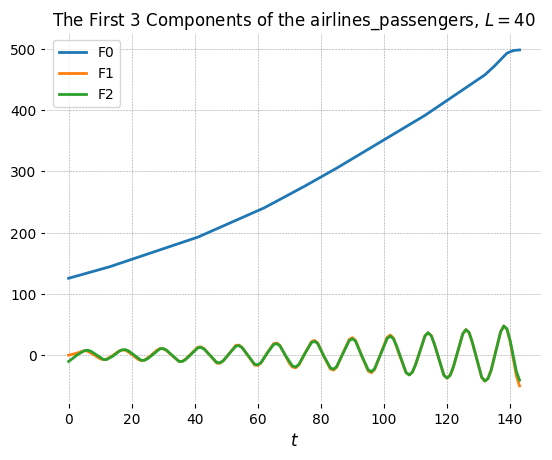

In [156]:
F_ssa_L40.components_to_df(n=3).plot()
plt.title(r"The First 3 Components of the airlines_passengers, $L=40$")
plt.xlabel(r"$t$");

Из приведенного выше графика видно, что периодическая компонента F2  содержит колебания той же частоты, что и периодическая компонента  F3 , что приводит к существенным w-корреляциям

Выводы:

Проведя сингулярный спектральный анализ временного ряда airlines_passengers, мы смогли выявить главный тренд, а также три различные компоненты сезонности, остальные компонены можно объединить в шум. Также провели эксперименты с разной длиной окна и визуализировали полученые результаты.

Проведем сингулярный спектральный анализ другого ряда. Посмотрим на динамику акций Лукойла

In [193]:
# загрузим данные
LKOH = pd.read_csv('LKOH.csv')

In [194]:
LKOH

,Дата,Цена,Откр.,Макс.,Мин.
0,20.12.2024,6731.0,6294.0,6801.5,6280.0
1,19.12.2024,6294.0,6379.5,6492.0,6263.0
2,18.12.2024,6375.0,6297.0,6395.0,6238.0
3,17.12.2024,6290.5,6330.0,6398.0,6256.0
4,16.12.2024,6779.5,6770.0,6787.5,6685.5
...,...,...,...,...,...
6472,13.01.1999,80.0,88.5,88.5,80.0
6473,12.01.1999,90.5,89.5,91.6,89.0
6474,11.01.1999,90.0,92.3,94.9,90.0
6475,06.01.1999,86.3,86.3,86.3,86.3


In [195]:
# преобразуем дату
LKOH['Дата'] = pd.to_datetime(LKOH['Дата'], format='%d.%m.%Y')
LKOH = LKOH.set_index('Дата')
LKOH.head()

,Цена,Откр.,Макс.,Мин.
Дата,,,,
2024-12-20,6731.0,6294.0,6801.5,6280.0
2024-12-19,6294.0,6379.5,6492.0,6263.0
2024-12-18,6375.0,6297.0,6395.0,6238.0
2024-12-17,6290.5,6330.0,6398.0,6256.0
2024-12-16,6779.5,6770.0,6787.5,6685.5


In [196]:
# поменяем столбцы местами
LKOH = LKOH[['Откр.', 'Макс.', 'Мин.', 'Цена']]
LKOH.head()

,Откр.,Макс.,Мин.,Цена
Дата,,,,
2024-12-20,6294.0,6801.5,6280.0,6731.0
2024-12-19,6379.5,6492.0,6263.0,6294.0
2024-12-18,6297.0,6395.0,6238.0,6375.0
2024-12-17,6330.0,6398.0,6256.0,6290.5
2024-12-16,6770.0,6787.5,6685.5,6779.5


In [197]:
# переименуем столбцы
LKOH.columns = ['Open', 'High', 'Low', 'Close']
LKOH.head()

,Open,High,Low,Close
Дата,,,,
2024-12-20,6294.0,6801.5,6280.0,6731.0
2024-12-19,6379.5,6492.0,6263.0,6294.0
2024-12-18,6297.0,6395.0,6238.0,6375.0
2024-12-17,6330.0,6398.0,6256.0,6290.5
2024-12-16,6770.0,6787.5,6685.5,6779.5


In [198]:
# отсортируем по дате
LKOH_sort = LKOH.sort_index()
LKOH_sort.head()

,Open,High,Low,Close
Дата,,,,
1999-01-05,84.0,84.3,84.0,84.0
1999-01-06,86.3,86.3,86.3,86.3
1999-01-11,92.3,94.9,90.0,90.0
1999-01-12,89.5,91.6,89.0,90.5
1999-01-13,88.5,88.5,80.0,80.0


In [199]:
# оставим данные с 2018 года
LKOH_sort = LKOH_sort['2018':]
LKOH_sort.head()

,Open,High,Low,Close
Дата,,,,
2018-01-03,3340.0,3421.5,3340.0,3421.5
2018-01-04,3428.0,3501.0,3392.5,3501.0
2018-01-05,3499.5,3569.5,3491.0,3569.5
2018-01-09,3575.0,3647.5,3575.0,3628.5
2018-01-10,3640.0,3649.0,3594.5,3641.0


Построим свечной график

In [200]:
!pip install --upgrade mplfinance

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


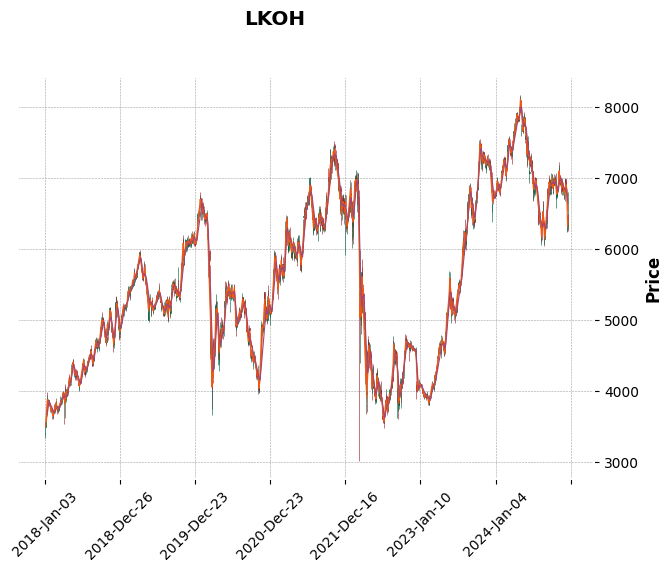

In [201]:
import mplfinance as mpf

mpf.plot(LKOH_sort, type='candle', style='charles', mav=(3, 6, 9), volume=False, title='LKOH')

In [202]:
# для дальнейшего разложения оставим только закрытые цены
LKOH_SSA = LKOH_sort['Close']
LKOH_SSA = LKOH_SSA.reset_index(drop=True)
LKOH_SSA

,Close
0,3421.5
1,3501.0
2,3569.5
3,3628.5
4,3641.0
...,...
1737,6779.5
1738,6290.5
1739,6375.0
1740,6294.0


In [203]:
len(LKOH_SSA)

1742

In [204]:
# длину окна возьмем равной 500
N = len(LKOH_SSA)
L = 500 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([LKOH_SSA[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive.

Text(0.5, 1.0, 'The Trajectory Matrix for LKOH')

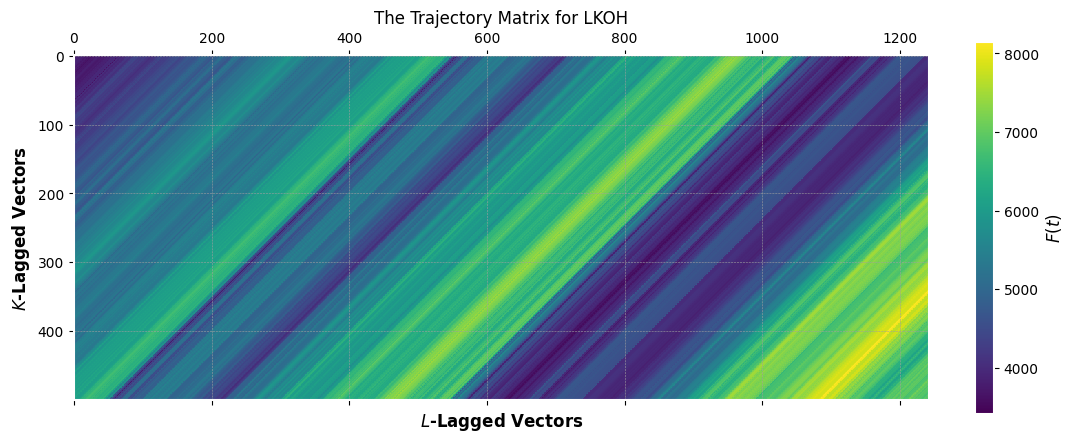

In [206]:
# возьмем момент, чтобы оценить матрицу траекторий во всей ее антидиагональной красоте:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for LKOH")

In [207]:
# разложим матрицу траекторий и сформируем ее элементарные матрицы:
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

In [209]:
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

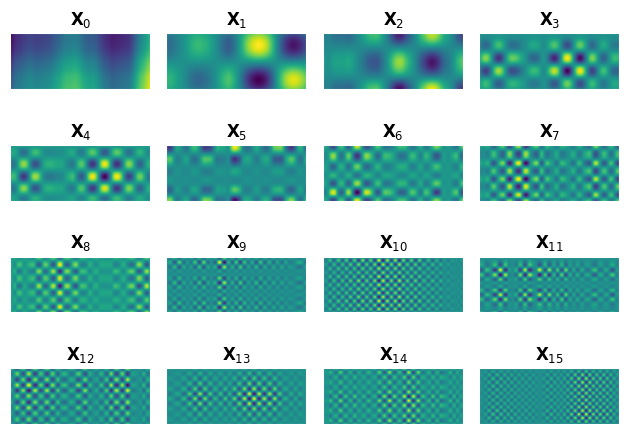

In [212]:
# рисуем элементарные матрицы
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

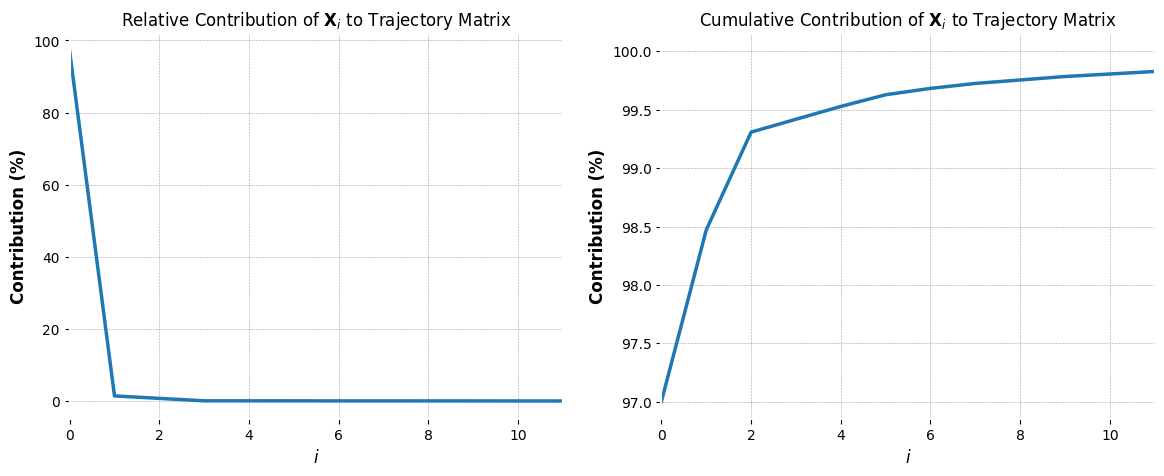

In [213]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Первые 3 признака дают основной вклад

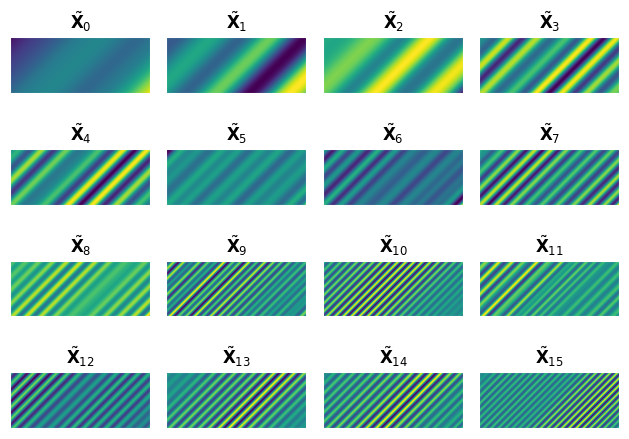

In [214]:
n = min(d, 16)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

X0 - главнй тренд, так же отдельными трендами могут быть Х1 и Х2. Следующие пары можно просуммировать друг с другом:
- Х3 и Х4
- Х5 и Х6
- Х7 и Х8
- Х9 и Х10
- Остальное - шум

In [215]:
F=LKOH_SSA

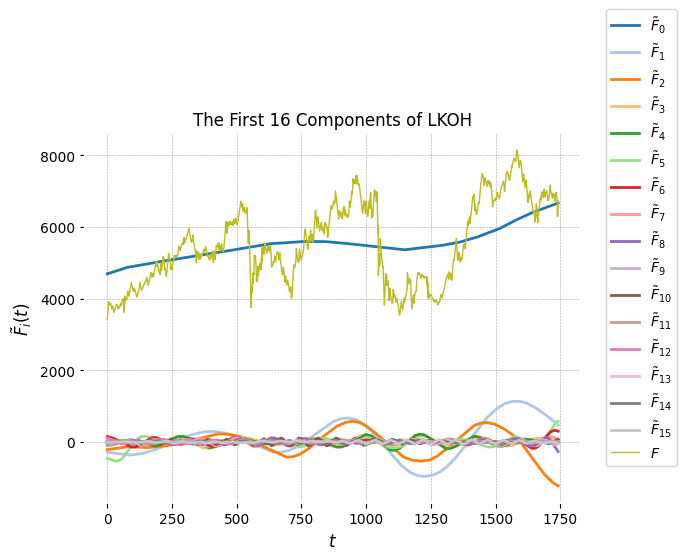

In [216]:
n = min(16,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 16 Components of LKOH")
fig.legend(legend, loc=(1.05,0.1));

На графике четко виден тренд (F0), сезонность 1 (F2) и сезонность 2 (F2)

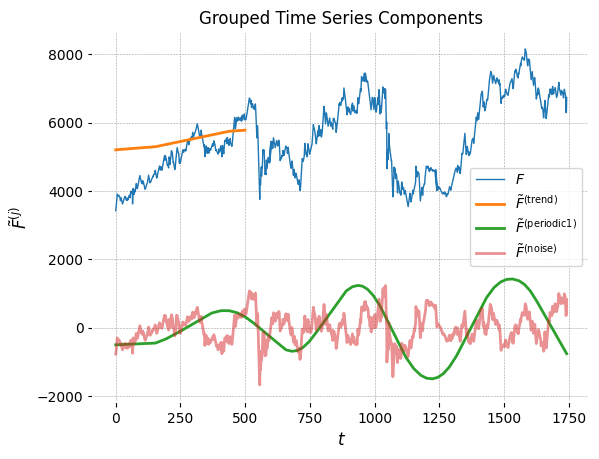

In [222]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]])
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
#F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[3:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(F, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)
#plt.plot(F_periodic2)
plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [223]:
# построим w-корреляционную матрицу для нашего временного ряда:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

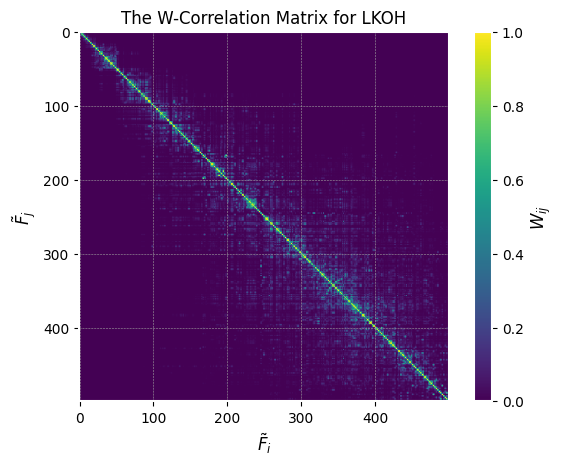

In [224]:
# График w-корреляционной матрицы
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for LKOH");

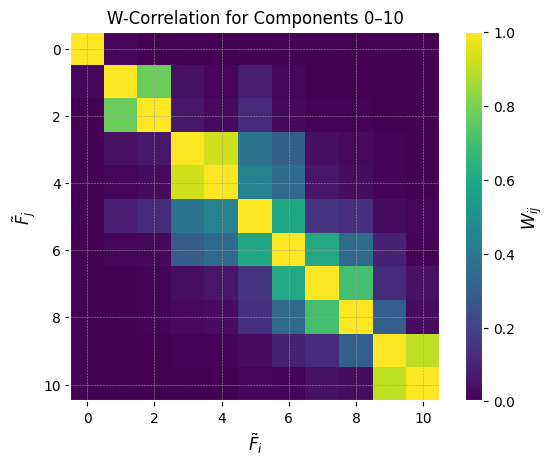

In [226]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,10.5)
plt.ylim(10.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–10");

Посмотрим на разные длины окна

L=2

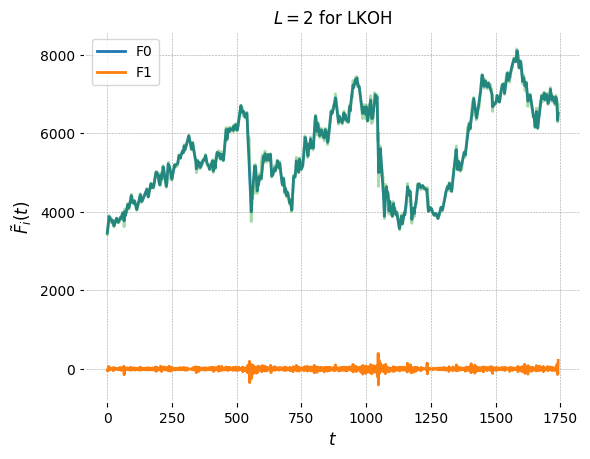

In [227]:
F_ssa_L2 = SSA(F, L=2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for LKOH");

L=5

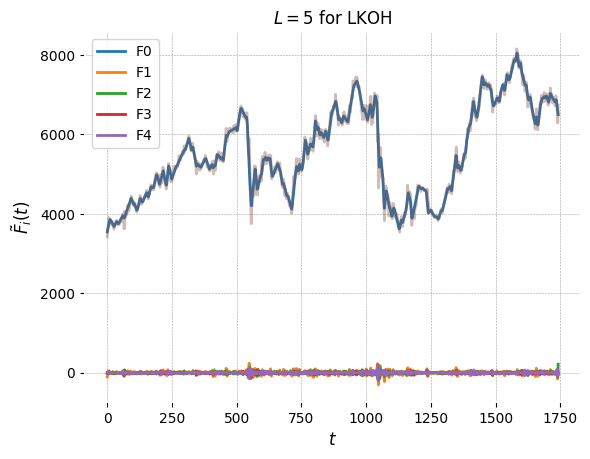

In [228]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for LKOH");
plt.show()

L=20

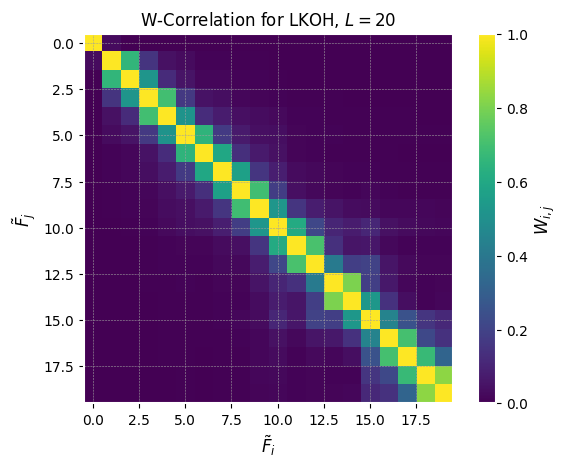

In [229]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for LKOH, $L=20$");

по w-корреляционной матрице для  L=20 трудно что-то понять, но попробуем  разбить (грубо) на пять блоков:
- F0
- F1 to F2
- F3 to F9
- F10 to F14
- F15 to F19.

Построим выбранные нами группировки компонентов и посмотрим, оправдан ли наш выбор группировки:

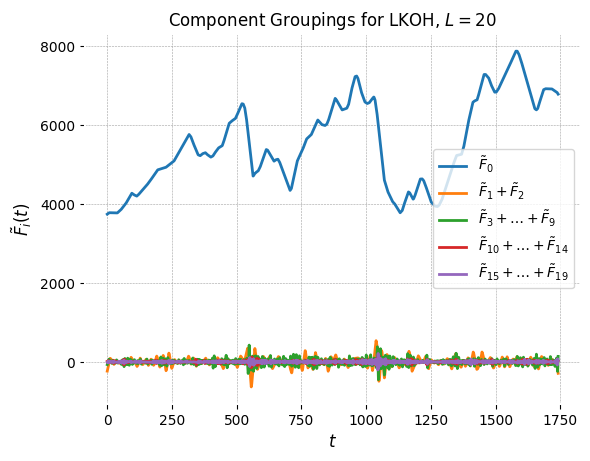

In [230]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2]).plot()
F_ssa_L20.reconstruct(slice(3,9)).plot()
F_ssa_L20.reconstruct(slice(10,14)).plot()
F_ssa_L20.reconstruct(slice(15,19)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for LKOH, $L=20$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+ \ldots + \tilde{F}_9$",
            r"$\tilde{F}_{10}+ \ldots +\tilde{F}_{14}$",
            r"$\tilde{F}_{15}+ \ldots + \tilde{F}_{19}$"]);

Разделение не самое удачное. Попробуем увеличить размер окна

L=40

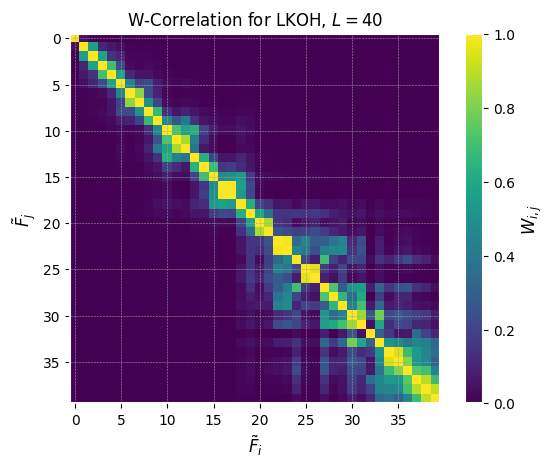

In [232]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for LKOH, $L=40$");

по w-корреляционной матрице для  L=40 можно разбить (грубо) на шесть блоков:
- F0
- F1 to F5
- F6 to F9
- F10 to F13
- F14 to F17
- F18 to F39.

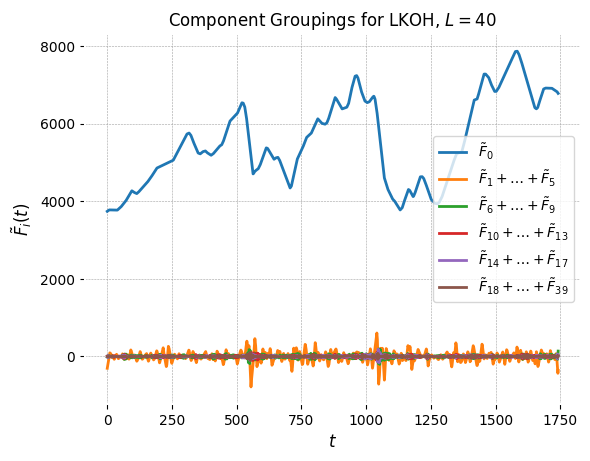

In [235]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct(slice(1,5)).plot()
F_ssa_L20.reconstruct(slice(6,9)).plot()
F_ssa_L20.reconstruct(slice(10,13)).plot()
F_ssa_L20.reconstruct(slice(14,17)).plot()
F_ssa_L20.reconstruct(slice(18,39)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for LKOH, $L=40$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+ \ldots + \tilde{F}_5$",
            r"$\tilde{F}_6+ \ldots + \tilde{F}_9$",
            r"$\tilde{F}_{10}+ \ldots + \tilde{F}_{13}$",
            r"$\tilde{F}_{14}+ \ldots +\tilde{F}_{17}$",
            r"$\tilde{F}_{18}+ \ldots + \tilde{F}_{39}$"]);

Разделение не самое удачное. Попробуем увеличить размер окна

L=100

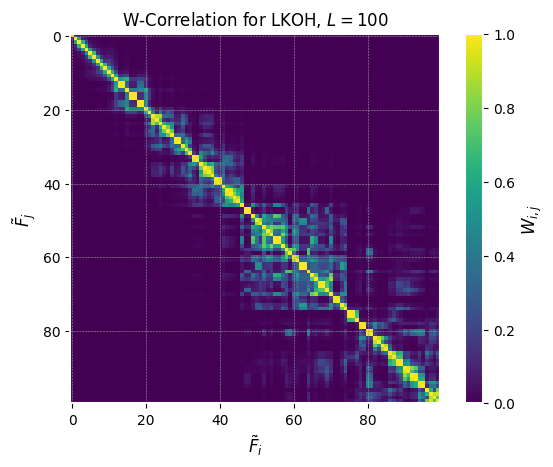

In [236]:
F_ssa_L100 = SSA(F, 100)
F_ssa_L100.plot_wcorr()
plt.title("W-Correlation for LKOH, $L=100$");

Стали выявляться четкие группы:
- F0
- F1 to F10
- F11 to F20
- F21 to F45
- F46 to F75
- F76 to F99

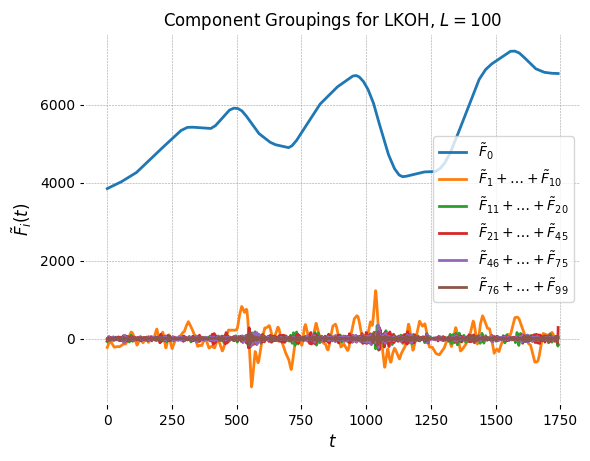

In [237]:
F_ssa_L100.reconstruct(0).plot()
F_ssa_L100.reconstruct(slice(1,10)).plot()
F_ssa_L100.reconstruct(slice(11,20)).plot()
F_ssa_L100.reconstruct(slice(21,45)).plot()
F_ssa_L100.reconstruct(slice(46,75)).plot()
F_ssa_L100.reconstruct(slice(76,99)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for LKOH, $L=100$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+ \ldots + \tilde{F}_{10}$",
            r"$\tilde{F}_{11}+ \ldots + \tilde{F}_{20}$",
            r"$\tilde{F}_{21}+ \ldots + \tilde{F}_{45}$",
            r"$\tilde{F}_{46}+ \ldots +\tilde{F}_{75}$",
            r"$\tilde{F}_{76}+ \ldots + \tilde{F}_{99}$"]);

Видно, что главный тренд стал сглаживаться и стали выделяться вспомогательные тренды

Предлагается оставить наше исследование, т.к. параметров очень много и уже достаточно трудно визуально определять по корреляционной матрице четкую границу закономерностей, тем более, что выше мы уже выявили главный тренд, сезонность и шум и с этим уже можно работать дальше

Выводы:

Проведя сингулярный спектральный анализ временного ряда динамики акций Лукойла, мы смогли выявить главный тренд, а также одну компоненту сезонности, остальные компонены можно объединить в шум. Помимо этого, был проведен эксперимент с разной длиной окна и визуализированы полученые результаты.


Выводы по работе:

Метод сингулярного спектрального анализа позволяет разложить временной ряд на различные компонены, выделяя главные, трендовые сезонные подкомпонены, которые в дальнейшем можно самостоятельно исследовать и строить прогнозы развития временного ряда